IMPORTS

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

LOAD DATA

In [8]:
df = pd.read_csv("/raw_dataset.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/raw_dataset.csv'

PREPROCESSING

In [4]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")

/tmp/ipython-input-87502532.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")


In [5]:
na_ratio = df.isna().mean()
very_sparse = na_ratio[na_ratio > 0.90].index.tolist()
nunique = df.nunique(dropna=True)
zero_var = nunique[nunique <= 1].index.tolist()
drop_cols = sorted(set(very_sparse + zero_var))

must_keep = ["Timestamp","DL_bitrate","UL_bitrate","PINGAVG","RTT","Latency","PINGMAX"]
for c in must_keep:
    if c in drop_cols:
        drop_cols.remove(c)

df.drop(columns=drop_cols, inplace=True, errors="ignore")


In [6]:
df["hour"] = df["Timestamp"].dt.hour
df["dayofweek"] = df["Timestamp"].dt.dayofweek
df["day"] = df["Timestamp"].dt.day
df["month"] = df["Timestamp"].dt.month
df["is_weekend"] = df["dayofweek"].isin([4,5]).astype(int)

df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24.0)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24.0)
df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7.0)
df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7.0)

In [7]:
def haversine(lat1, lon1, lat2, lon2):
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 6371 * (2*np.arcsin(np.sqrt(a)))

def bearing(lat1, lon1, lat2, lon2):
    dlon = lon2 - lon1
    x = np.sin(dlon)*np.cos(lat2)
    y = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dlon)
    return (np.degrees(np.arctan2(x,y))+360)%360

for c in ["Latitude","Longitude","Node_Latitude","Node_Longitude"]:
    if c not in df.columns: df[c] = np.nan

lat1, lon1 = np.radians(df["Latitude"]), np.radians(df["Longitude"])
lat2, lon2 = np.radians(df["Node_Latitude"]), np.radians(df["Node_Longitude"])

df["dist_to_node_km"] = haversine(lat1, lon1, lat2, lon2)
df["bearing_to_node"] = bearing(lat1, lon1, lat2, lon2)

In [8]:
def signal_bucket(row):
    if "SINR" in row.index and pd.notna(row["SINR"]):
        v = row["SINR"]
        return "Poor" if v < 0 else "Fair" if v < 5 else "Good" if v < 12 else "Excellent"
    if "SNR" in row.index and pd.notna(row["SNR"]):
        v = row["SNR"]
        return "Poor" if v < 0 else "Fair" if v < 5 else "Good" if v < 12 else "Excellent"
    if "RSRP" in row.index and pd.notna(row["RSRP"]):
        v = row["RSRP"]
        return "Poor" if v < -110 else "Fair" if v < -100 else "Good" if v < -90 else "Excellent"
    if "Level" in row.index and pd.notna(row["Level"]):
        v = row["Level"]
        return "Poor" if v < -95 else "Fair" if v < -85 else "Good" if v < -75 else "Excellent"
    return "Unknown"


In [9]:
if "SessionID" not in df.columns: df["SessionID"] = 0
df = df.sort_values(["SessionID","Timestamp"])

target_kpis = ["DL_bitrate", "UL_bitrate", "PINGAVG", "RTT", "Latency", "PINGMAX"]

num_cols_for_lags = [
    c for c in df.select_dtypes(include=[np.number]).columns
    if c not in target_kpis and c != "SessionID"
]

for col in num_cols_for_lags:
    grp = df.groupby("SessionID")[col]
    df[f"{col}_lag1"] = grp.shift(1)
    df[f"{col}_roll3"] = grp.apply(lambda s: s.shift(1).rolling(3).mean()).reset_index(level=0, drop=True)



In [10]:
neighbor_cols = [c for c in df.columns if c.startswith("N") or c.startswith("SecondCell_")]
if neighbor_cols:
    neigh_num = df[neighbor_cols].select_dtypes(include=[np.number])
    if not neigh_num.empty:
        df["Neighbor_mean"] = neigh_num.mean(axis=1, skipna=True)
        df["Neighbor_std"] = neigh_num.std(axis=1, skipna=True)

In [11]:
TARGETS = {}

if "DL_bitrate" in df.columns:
    TARGETS["y_downlink_throughput"] = df["DL_bitrate"]

if "UL_bitrate" in df.columns:
    TARGETS["y_uplink_throughput"] = df["UL_bitrate"]

for pref in ["PINGAVG", "RTT", "Latency", "PINGMAX"]:
    if pref in df.columns:
        TARGETS["y_latency"] = df[pref]
        break

print("Target columns ready:", list(TARGETS.keys()))


Target columns ready: ['y_downlink_throughput', 'y_uplink_throughput', 'y_latency']


In [12]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.maps_ = {}
        self.columns_ = None

    def fit(self, X, y=None):
        X = pd.DataFrame(X).copy()
        self.columns_ = X.columns.tolist()
        for c in self.columns_:
            vc = X[c].value_counts(dropna=False)
            self.maps_[c] = (vc / vc.sum()).to_dict()
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        return np.vstack([X[c].map(self.maps_[c]).fillna(0.0).to_numpy() for c in self.columns_]).T

    def get_feature_names_out(self, input_features=None):
        if self.columns_ is None:
            return []
        return [f"{col}_freq" for col in self.columns_]



raw_target_cols = [c for c in ["DL_bitrate", "UL_bitrate", "TESTDOWNLINK", "TESTUPLINK",
                               "PINGAVG", "PINGMIN", "PINGMAX", "RTT", "Latency"]
                   if c in df.columns]

exclude = set(["Timestamp"]) | set(TARGETS.keys()) | set(raw_target_cols)

feature_cols = [c for c in df.columns if c not in exclude]


cat_cols = df[feature_cols].select_dtypes(include=["object"]).columns.tolist()
num_cols = df[feature_cols].select_dtypes(include=[np.number,"bool"]).columns.tolist()

low_card = [c for c in cat_cols if df[c].nunique(dropna=True) <= 30]
high_card = [c for c in cat_cols if df[c].nunique(dropna=True) > 30]

num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
cat_low_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])
cat_high_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                          ("freq", FrequencyEncoder())])

preprocessor = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat_low", cat_low_pipe, low_card),
    ("cat_high", cat_high_pipe, high_card),
], remainder="drop", verbose_feature_names_out=False)


In [13]:
X_raw = df[feature_cols].copy()
y_df = pd.DataFrame(TARGETS)

session_ids = df["SessionID"].unique()

train_sessions, test_sessions = train_test_split(
    session_ids, test_size=0.2, random_state=42
)

train_idx = df[df["SessionID"].isin(train_sessions)].index
test_idx  = df[df["SessionID"].isin(test_sessions)].index

X_train_raw = X_raw.loc[train_idx]
X_test_raw  = X_raw.loc[test_idx]

preprocessor.fit(X_train_raw)

Xt_train = preprocessor.transform(X_train_raw)
Xt_test  = preprocessor.transform(X_test_raw)

feature_names = preprocessor.get_feature_names_out()
X_train = pd.DataFrame(Xt_train, index=X_train_raw.index, columns=feature_names)
X_test  = pd.DataFrame(Xt_test,  index=X_test_raw.index,  columns=feature_names)

y_train_ul = np.log1p(y_df.loc[X_train.index, "y_uplink_throughput"])
y_test_ul  = np.log1p(y_df.loc[X_test.index,  "y_uplink_throughput"])

y_train_dl = np.log1p(y_df.loc[X_train.index, "y_downlink_throughput"])
y_test_dl  = np.log1p(y_df.loc[X_test.index,  "y_downlink_throughput"])

X_train_ul, X_test_ul = X_train.copy(), X_test.copy()
X_train_dl, X_test_dl = X_train.copy(), X_test.copy()

print("Shapes check:")
print("X_train:", X_train.shape, " y_train_ul:", y_train_ul.shape)
print("X_test :", X_test.shape,  " y_test_ul :", y_test_ul.shape)

assert len(X_train) == len(y_train_ul), "Mismatch between X_train and y_train_ul"
assert len(X_test)  == len(y_test_ul),  "Mismatch between X_test and y_test_ul"

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['hour' 'dayofweek' 'day' 'month' 'hour_sin' 'hour_cos' 'dow_sin'
 'dow_cos' 'hour_lag1' 'hour_roll3' 'dayofweek_lag1' 'dayofweek_roll3'
 'day_lag1' 'day_roll3' 'month_lag1' 'month_roll3' 'hour_sin_lag1'
 'hour_sin_roll3' 'hour_cos_lag1' 'hour_cos_roll3' 'dow_sin_lag1'
 'dow_sin_roll3' 'dow_cos_lag1' 'dow_cos_roll3']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['hour' 'dayofweek' 'day' 'month' 'hour_sin' 'hour_cos' 'dow_sin'
 'dow_cos' 'hour_lag1' 'hour_roll3' 'dayofweek_lag1' 'dayofweek_roll3'
 'day_lag1' 'day_roll3' 'month_lag1' 'month_roll3' 'hour_sin_lag1'
 'hour_sin_roll3' 'hour_cos_lag1' 'hour_cos_roll3' 'dow_sin_lag1'
 'dow_sin_roll3' 'dow_cos_lag1' 'dow_cos_roll3']. At le

Shapes check:
X_train: (23201, 106)  y_train_ul: (23201,)
X_test : (7724, 106)  y_test_ul : (7724,)


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['hour' 'dayofweek' 'day' 'month' 'hour_sin' 'hour_cos' 'dow_sin'
 'dow_cos' 'hour_lag1' 'hour_roll3' 'dayofweek_lag1' 'dayofweek_roll3'
 'day_lag1' 'day_roll3' 'month_lag1' 'month_roll3' 'hour_sin_lag1'
 'hour_sin_roll3' 'hour_cos_lag1' 'hour_cos_roll3' 'dow_sin_lag1'
 'dow_sin_roll3' 'dow_cos_lag1' 'dow_cos_roll3']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [14]:
raw_target_cols = [c for c in ["DL_bitrate", "UL_bitrate", "TESTDOWNLINK", "TESTUPLINK",
                               "PINGAVG", "PINGMIN", "PINGMAX", "RTT", "Latency"]
                   if c in df.columns]

num_train = X_train_raw.select_dtypes(include=[np.number]).drop(
    columns=[c for c in raw_target_cols if c in X_train_raw.columns], errors="ignore"
)
num_test = X_test_raw.select_dtypes(include=[np.number]).drop(
    columns=[c for c in raw_target_cols if c in X_test_raw.columns], errors="ignore"
)

train_medians = num_train.median(numeric_only=True)
num_train_imp = num_train.fillna(train_medians).fillna(0.0)
num_test_imp  = num_test.fillna(train_medians).fillna(0.0)

iso = IsolationForest(n_estimators=200, contamination="auto", random_state=42)
iso.fit(num_train_imp)

anom_pred_train = iso.predict(num_train_imp)  # -1 = anomaly, 1 = normal
anom_pred_test  = iso.predict(num_test_imp)

y_train_anom = pd.Series((anom_pred_train == -1).astype(int),
                         index=X_train_raw.index, name="y_anomaly")
y_test_anom  = pd.Series((anom_pred_test == -1).astype(int),
                         index=X_test_raw.index,  name="y_anomaly")

print("IsolationForest (session-safe):",
      f"{y_train_anom.sum()} train anomalies / {len(y_train_anom)} rows,",
      f"{y_test_anom.sum()} test anomalies / {len(y_test_anom)} rows")


IsolationForest (session-safe): 3018 train anomalies / 23201 rows, 1519 test anomalies / 7724 rows


In [15]:
if "y_downlink_throughput_log" in y_df:
    y_train_dl = y_df.loc[X_train.index, "y_downlink_throughput_log"]
    y_test_dl  = y_df.loc[X_test.index,  "y_downlink_throughput_log"]
    print("Split ready for downlink throughput (log-transformed)")


if "y_uplink_throughput_log" in y_df:
    y_train_ul = y_df.loc[X_train.index, "y_uplink_throughput_log"]
    y_test_ul  = y_df.loc[X_test.index,  "y_uplink_throughput_log"]
    print("Split ready for uplink throughput (log-transformed)")

if "y_anomaly" in y_df:
    y_train_anom = y_df.loc[X_train.index, "y_anomaly"]
    y_test_anom  = y_df.loc[X_test.index,  "y_anomaly"]
    print("Split ready for anomaly detection")


In [16]:
full_data = pd.concat([X_raw, y_df], axis=1)
full_data.to_csv("cleaned_ready_for_modeling.csv", index=False)
print("Saved:", full_data.shape, "to cleaned_ready_for_modeling.csv")


Saved: (30925, 124) to cleaned_ready_for_modeling.csv


Exploratory Data Analysis

In [21]:
print("Shape:", df.shape)

shape: (30925, 126)


In [23]:
print("Columns:", df.columns.tolist())

Columns: ['Timestamp', 'Longitude', 'Latitude', 'Speed', 'Operatorname', 'Node', 'CellID', 'NetworkTech', 'Level', 'Qual', 'SNR', 'CQI', 'LTERSSI', 'DL_bitrate', 'UL_bitrate', 'PSC', 'Altitude', 'Accuracy', 'State', 'SERVINGTIME', 'SecondCell_NODE', 'SecondCell_CELLID', 'SecondCell_RSRP', 'SecondCell_SNR', 'SecondCell_PSC', 'NTech1', 'NCellid1', 'NLAC1', 'NCell1', 'NRxLev1', 'NQual1', 'PINGAVG', 'PINGMAX', 'Test_Status', 'Mobility', 'Node_Longitude', 'Node_Latitude', 'SessionID', 'ElapsedTime', 'hour', 'dayofweek', 'day', 'month', 'is_weekend', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'dist_to_node_km', 'bearing_to_node', 'Longitude_lag1', 'Longitude_roll3', 'Latitude_lag1', 'Latitude_roll3', 'Speed_lag1', 'Speed_roll3', 'Node_lag1', 'Node_roll3', 'CellID_lag1', 'CellID_roll3', 'Level_lag1', 'Level_roll3', 'Qual_lag1', 'Qual_roll3', 'SNR_lag1', 'SNR_roll3', 'CQI_lag1', 'CQI_roll3', 'LTERSSI_lag1', 'LTERSSI_roll3', 'PSC_lag1', 'PSC_roll3', 'Altitude_lag1', 'Altitude_roll3', 'Accura

In [24]:
print("Missingvalues", df.isnull().sum)

Missingvalues <bound method DataFrame.sum of        Timestamp  Longitude  Latitude  Speed  Operatorname   Node  CellID  \
0           True      False     False  False         False  False   False   
1           True      False     False  False         False  False   False   
2           True      False     False  False         False  False   False   
3           True      False     False  False         False  False   False   
4           True      False     False  False         False  False   False   
...          ...        ...       ...    ...           ...    ...     ...   
28010       True      False     False  False         False  False   False   
28011       True      False     False  False         False  False   False   
28012       True      False     False  False         False  False   False   
28013       True      False     False  False         False  False   False   
28014       True      False     False  False         False  False   False   

       NetworkTech  Level   Qu

In [26]:
print("Missing values (top 10):\n", df.isnull().sum().sort_values(ascending=False).head(10))

Missing values (top 10):
 Timestamp       30925
dayofweek       30925
hour_cos        30925
hour_sin        30925
day             30925
month           30925
dow_sin         30925
dow_cos         30925
hour            30925
dow_sin_lag1    30925
dtype: int64


In [33]:
Targets=['DL_bitrate','UL_bitrate','PINGAVG']
print("Summery Statistics for Throughput:\n")
print(df[Targets].describe(percentiles=[0.01,0.25,0.5,0.75,0.99]))

Summery Statistics for Throughput:

          DL_bitrate    UL_bitrate     PINGAVG
count   30925.000000  30925.000000   66.000000
mean      793.651803    384.196055   88.428030
std      4057.478494   1601.638857   51.074635
min         0.000000      0.000000   20.000000
1%          0.000000      0.000000   22.600000
25%         0.000000      0.000000   53.500000
50%         0.000000      0.000000   73.000000
75%        13.000000     13.000000  112.750000
99%     21211.320000   8897.760000  201.625000
max    103893.000000  18479.000000  201.625000


In [48]:
print("\n% of Zero Values:")
print((df[Targets] == 0).sum() / len(df) * 100)


% of Zero Values:
DL_bitrate    69.597413
UL_bitrate    63.524656
PINGAVG        0.000000
dtype: float64


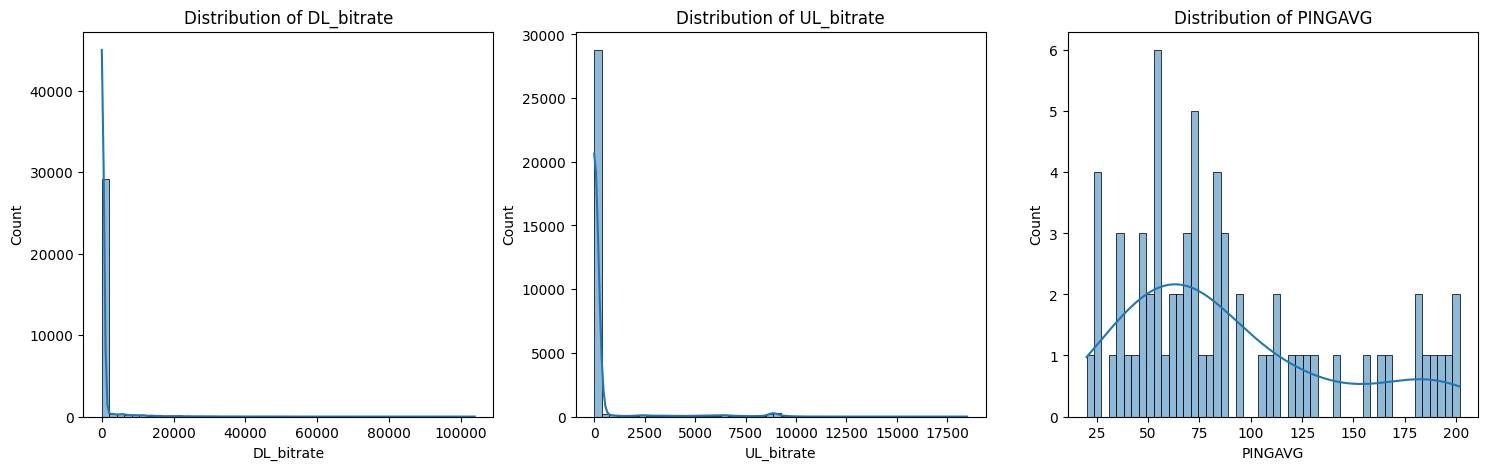

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
for i, col in enumerate(Targets):
    sns.histplot(df[col].dropna(), bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
plt.show()

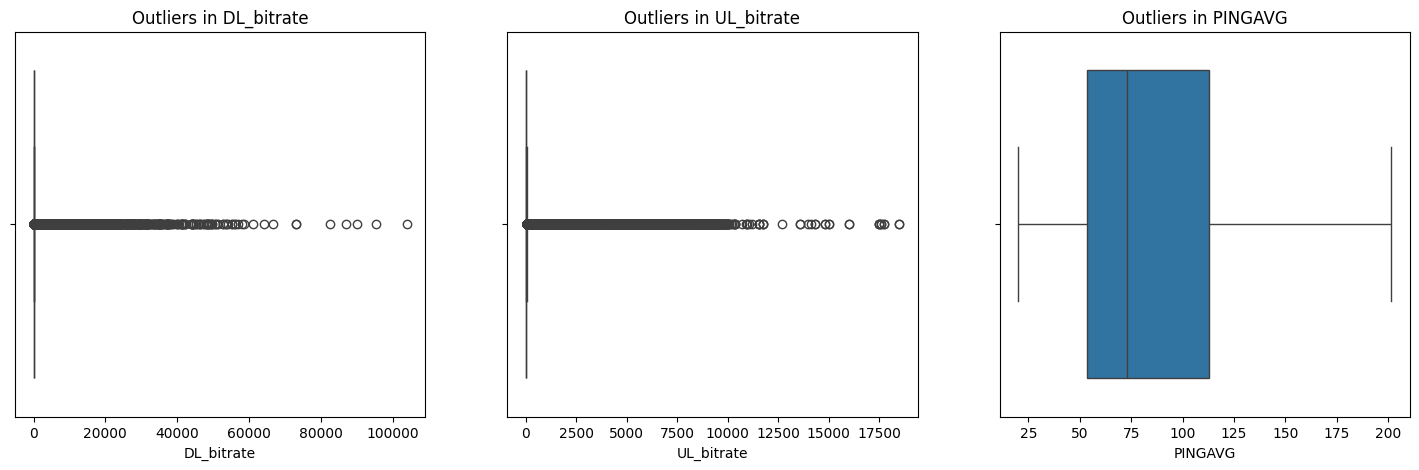

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
for i, col in enumerate(Targets):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f"Outliers in {col}")
plt.show()

In [49]:
num_cols = df.select_dtypes(include=['float64','int64']).columns
corr_matrix = df[num_cols].corr()

print("Correlation with Targets")
print(corr_matrix[Targets].sort_values(by="DL_bitrate", ascending=False).head(10))

Correlation with Targets
                   DL_bitrate  UL_bitrate   PINGAVG
DL_bitrate           1.000000    0.011962 -0.027151
SessionID            0.073273    0.039344  0.321044
Qual                 0.032910    0.111048  0.326710
NLAC1                0.021557    0.073763  0.285369
SNR                  0.021415    0.047099  0.239554
CellID               0.015868   -0.007751  0.074224
ElapsedTime          0.015024   -0.078521  0.126804
ElapsedTime_lag1     0.014810   -0.078551  0.126904
ElapsedTime_roll3    0.014464   -0.078876  0.126996
NLAC1_roll3          0.014324    0.077420  0.309888


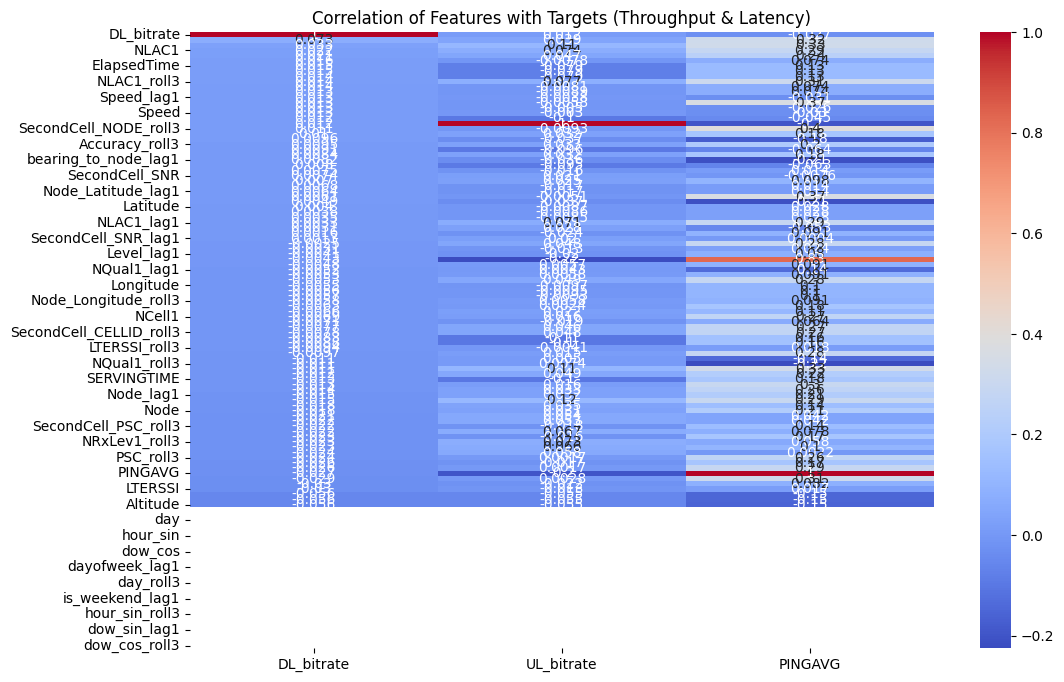

In [38]:
num_cols = df.select_dtypes(include=['float64','int64']).columns
corr = df[num_cols].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr[Targets].sort_values(by='DL_bitrate', ascending=False),
            annot=True, cmap="coolwarm", cbar=True)
plt.title("Correlation of Features with Targets (Throughput & Latency)")
plt.show()

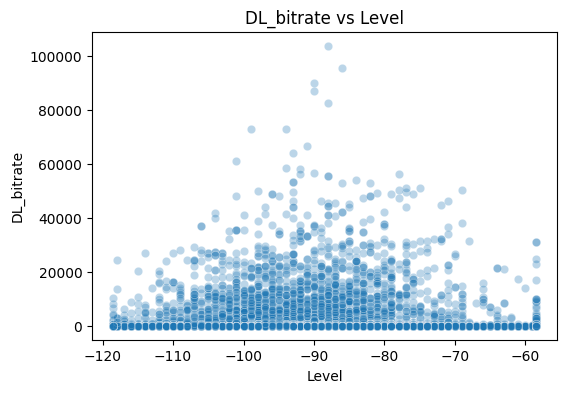

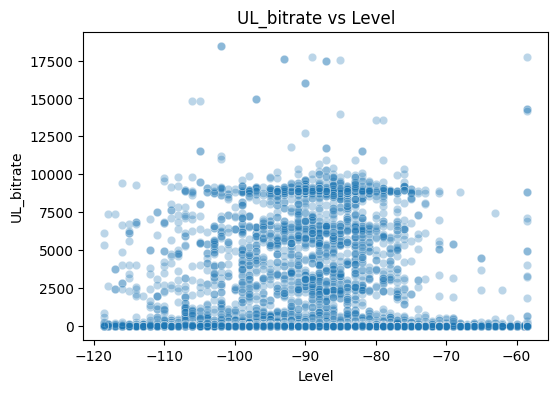

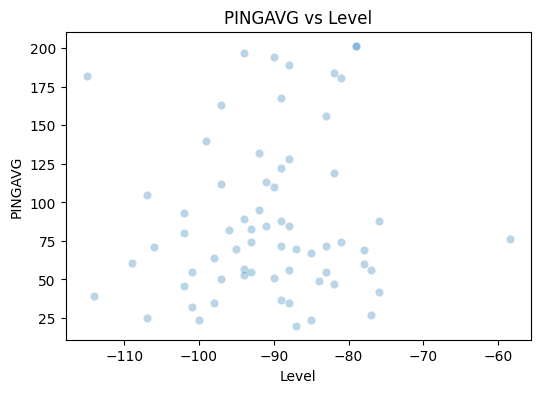

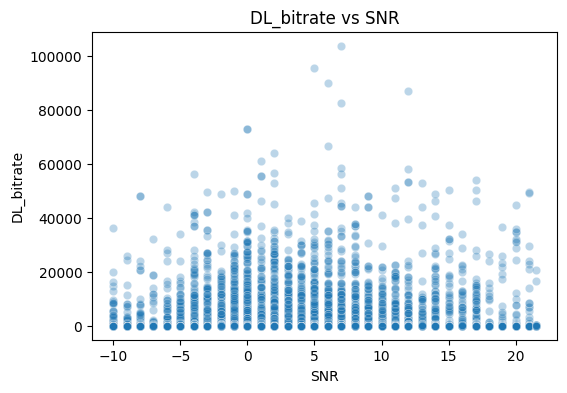

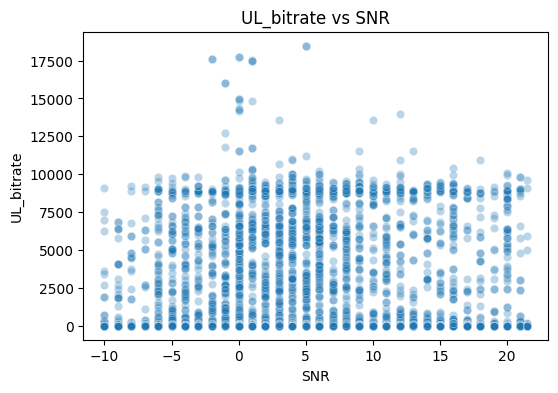

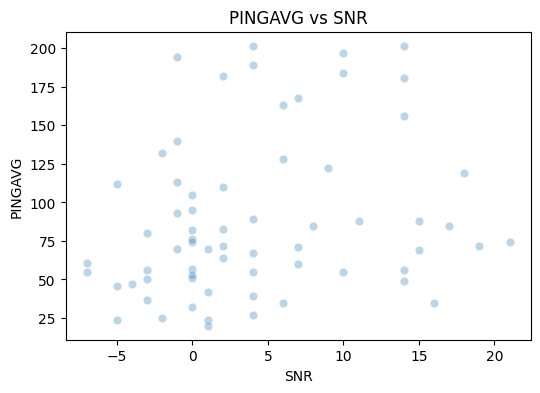

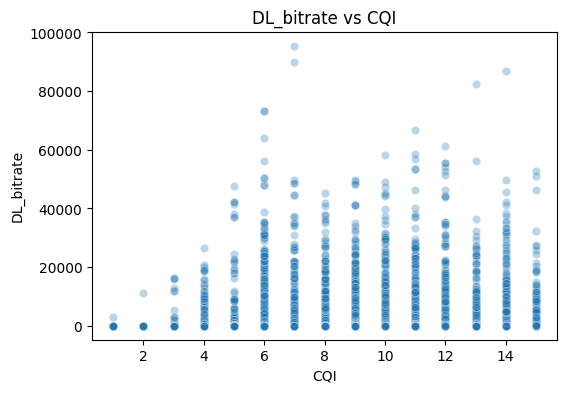

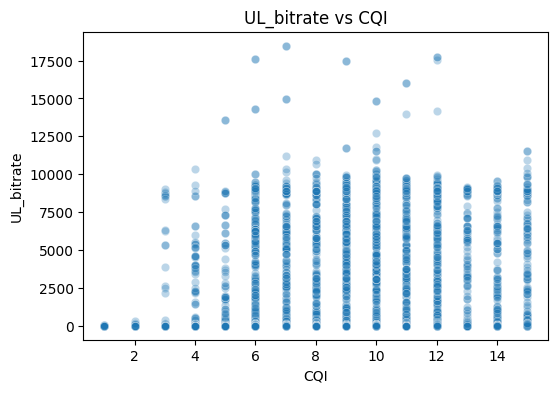

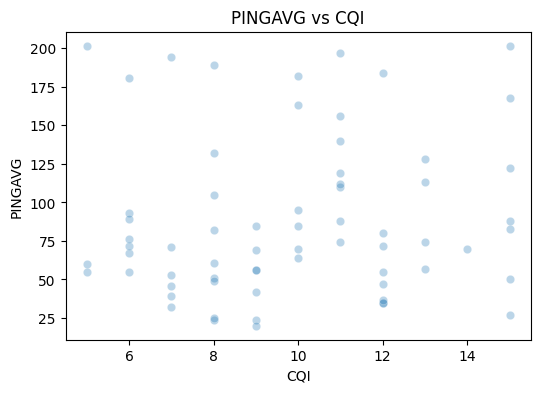

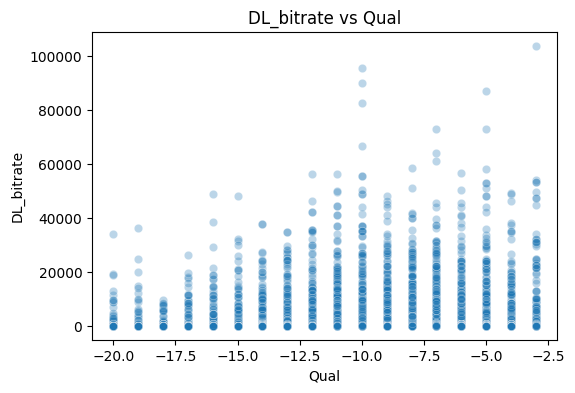

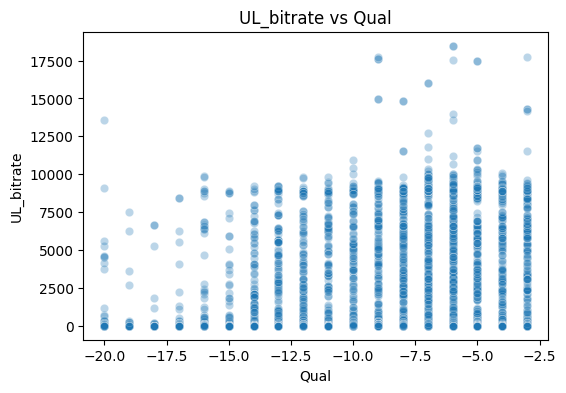

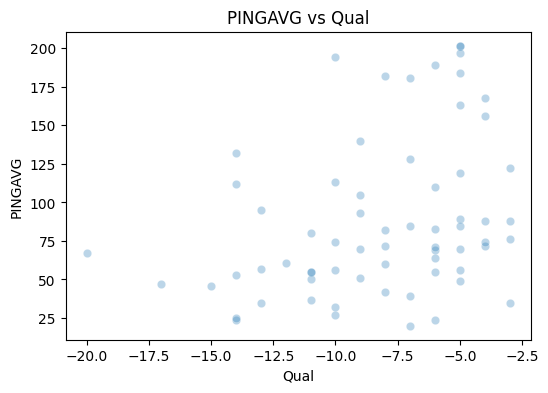

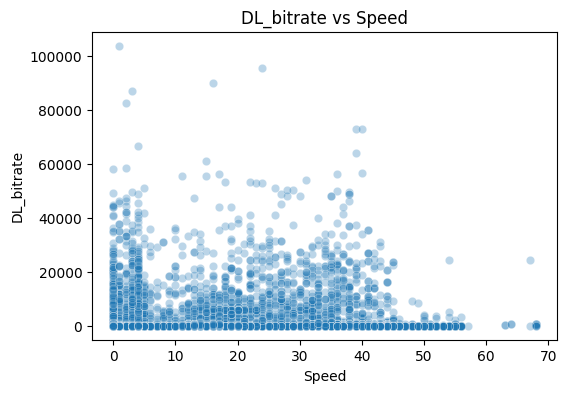

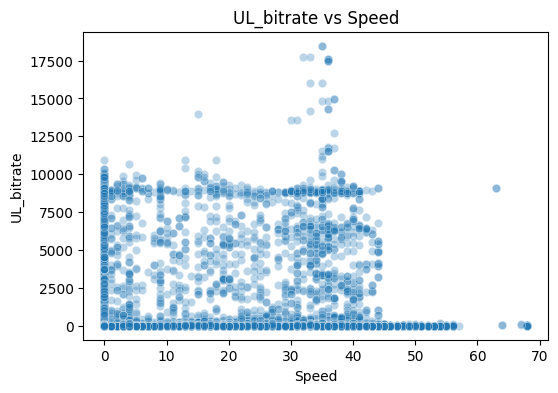

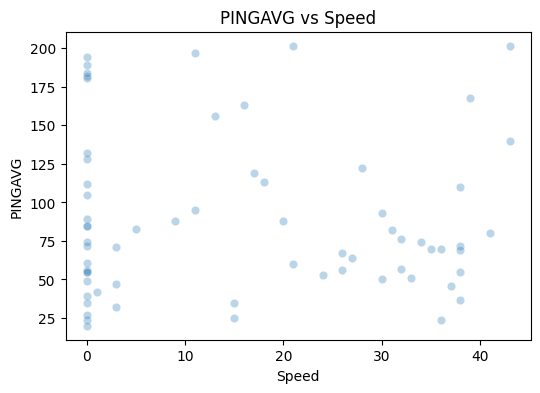

In [40]:
features_to_check = ['Level','SNR','CQI','Qual','Speed','BANDWIDTH']

for col in features_to_check:
    if col in df.columns:
        for target in Targets:
            plt.figure(figsize=(6,4))
            sns.scatterplot(data=df, x=col, y=target, alpha=0.3)
            plt.title(f"{target} vs {col}")
            plt.show()

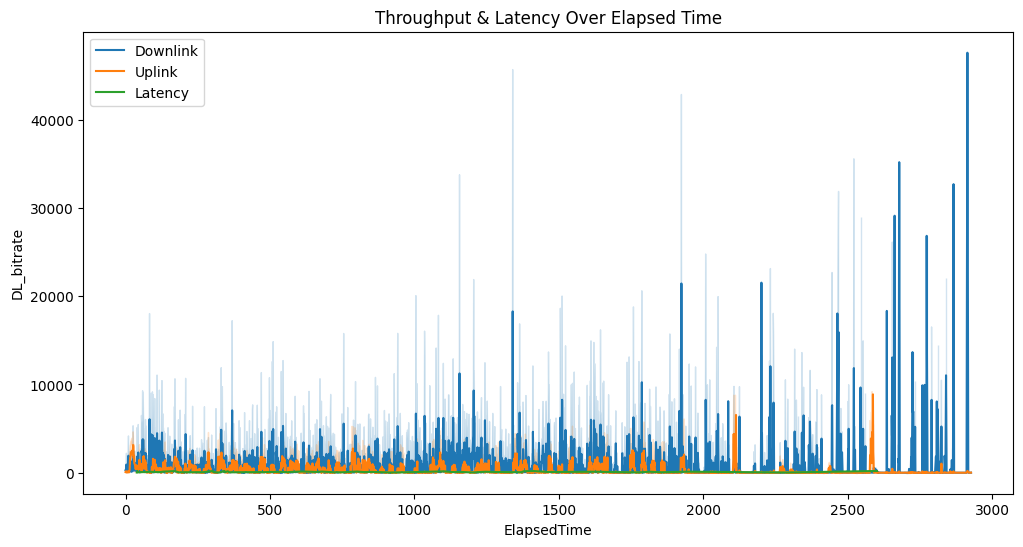

In [41]:
if 'ElapsedTime' in df.columns:
    plt.figure(figsize=(12,6))
    sns.lineplot(data=df, x='ElapsedTime', y='DL_bitrate', label='Downlink')
    sns.lineplot(data=df, x='ElapsedTime', y='UL_bitrate', label='Uplink')
    sns.lineplot(data=df, x='ElapsedTime', y='PINGAVG', label='Latency')
    plt.title("Throughput & Latency Over Elapsed Time")
    plt.legend()
    plt.show()


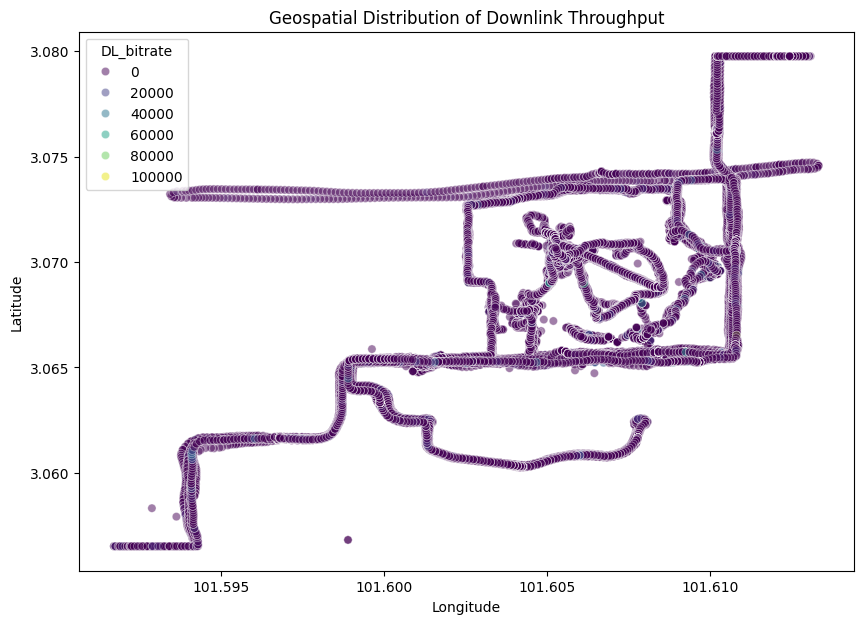

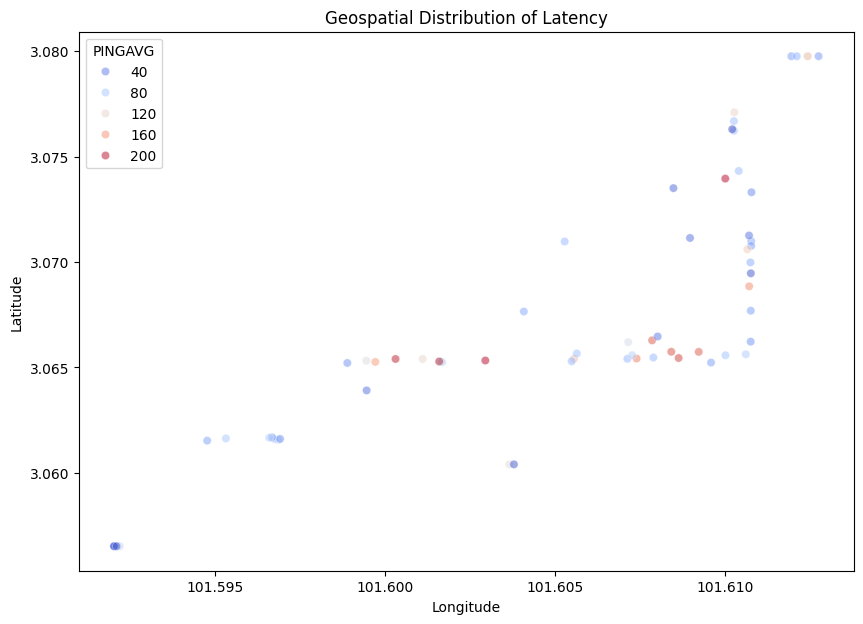

In [44]:
if 'Longitude' in df.columns and 'Latitude' in df.columns:
    plt.figure(figsize=(10,7))
    sns.scatterplot(data=df, x='Longitude', y='Latitude',
                    hue='DL_bitrate', palette='viridis', alpha=0.5)
    plt.title("Geospatial Distribution of Downlink Throughput")
    plt.show()
    plt.figure(figsize=(10,7))
    sns.scatterplot(data=df, x='Longitude', y='Latitude',
                    hue='PINGAVG', palette='coolwarm', alpha=0.5)
    plt.title("Geospatial Distribution of Latency")
    plt.show()

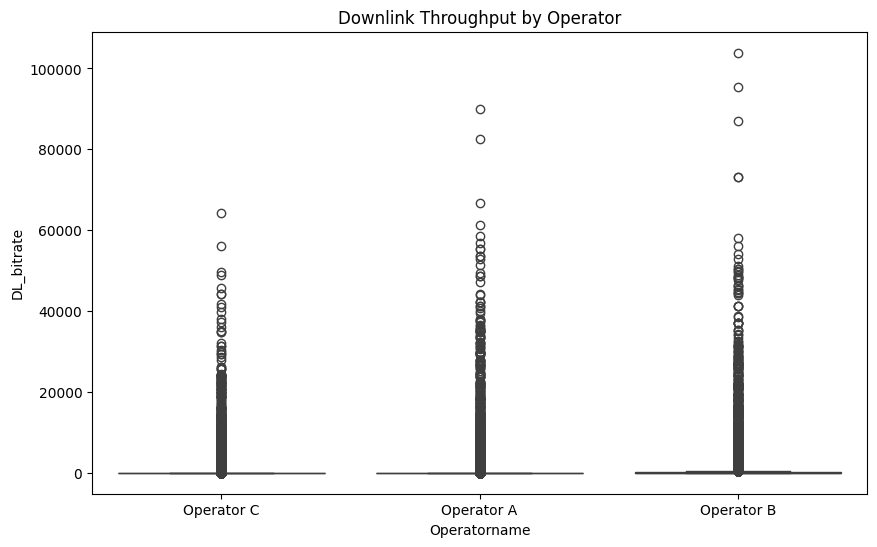

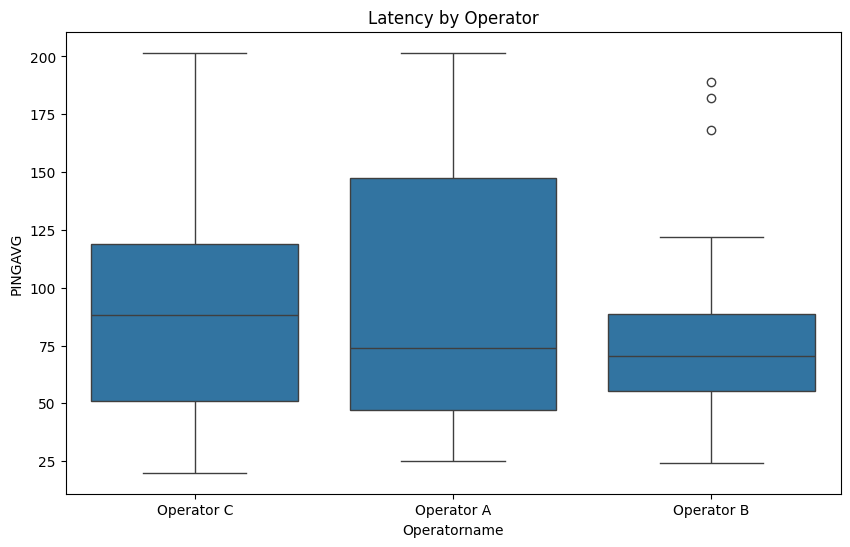

In [45]:
if 'Operatorname' in df.columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(data=df, x='Operatorname', y='DL_bitrate')
    plt.title("Downlink Throughput by Operator")
    plt.show()

    plt.figure(figsize=(10,6))
    sns.boxplot(data=df, x='Operatorname', y='PINGAVG')
    plt.title("Latency by Operator")
    plt.show()


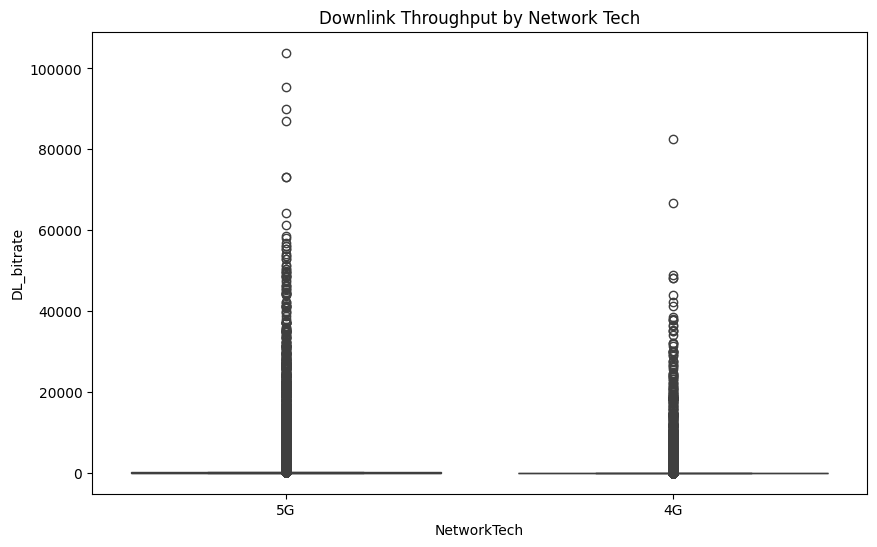

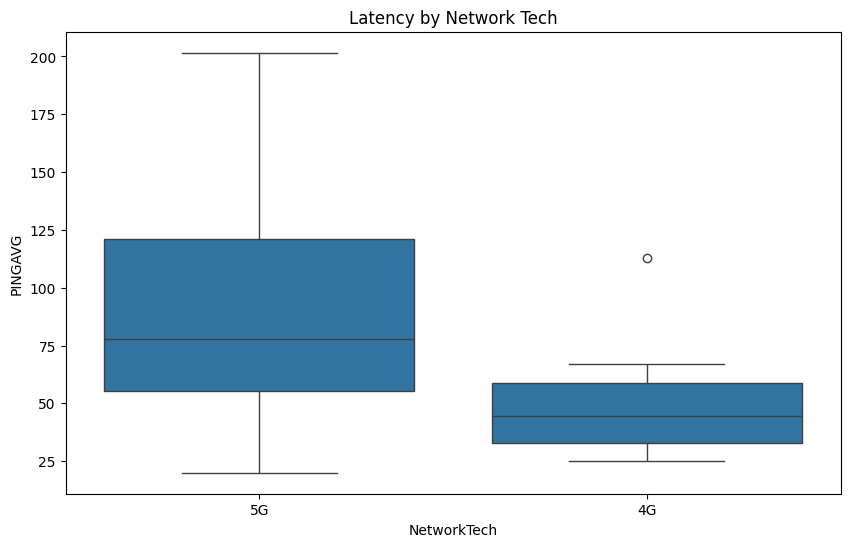

In [46]:
if 'NetworkTech' in df.columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(data=df, x='NetworkTech', y='DL_bitrate')
    plt.title("Downlink Throughput by Network Tech")
    plt.show()

    plt.figure(figsize=(10,6))
    sns.boxplot(data=df, x='NetworkTech', y='PINGAVG')
    plt.title("Latency by Network Tech")
    plt.show()


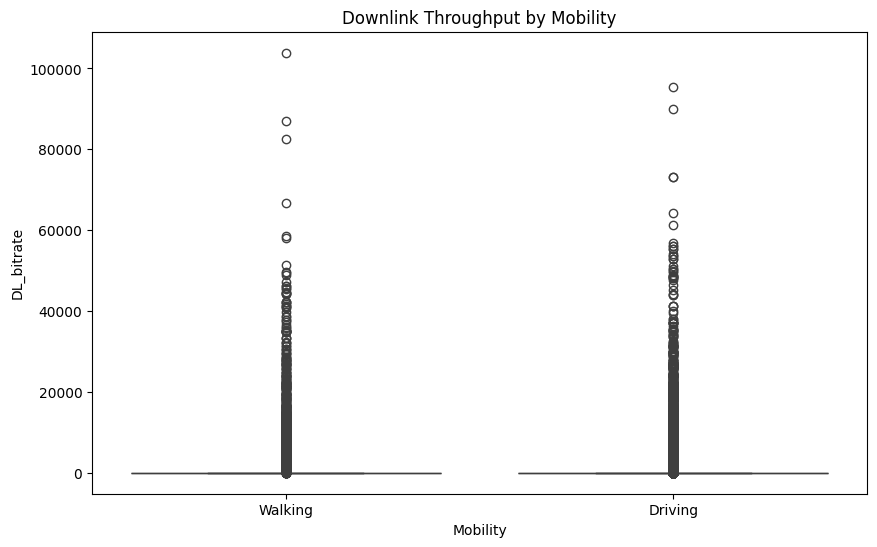

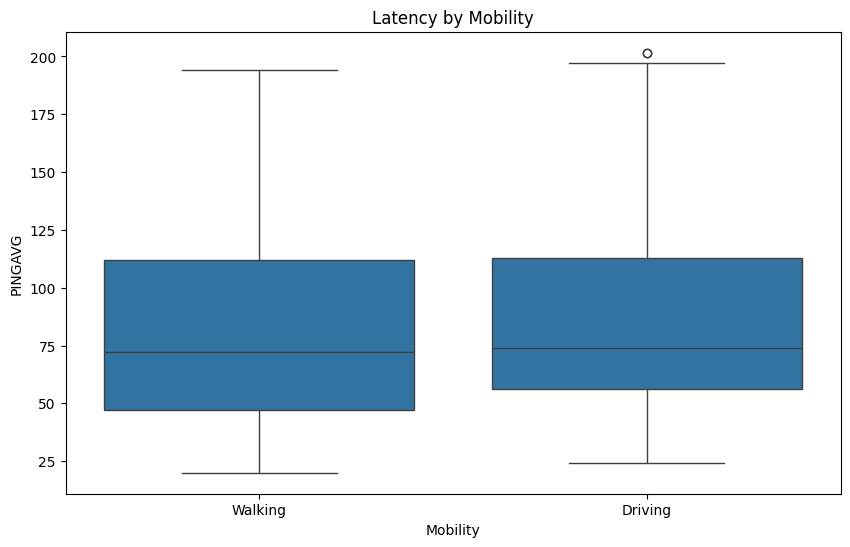

In [47]:

if 'Mobility' in df.columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(data=df, x='Mobility', y='DL_bitrate')
    plt.title("Downlink Throughput by Mobility")
    plt.show()

    plt.figure(figsize=(10,6))
    sns.boxplot(data=df, x='Mobility', y='PINGAVG')
    plt.title("Latency by Mobility")
    plt.show()

In [56]:
if 'NetworkTech' in df.columns:
    print("Avg Throughput & Latency by NetworkTech")
    print(df.groupby('NetworkTech')[Targets].mean().round(2))

if 'Operatorname' in df.columns:
    print("Avg Throughput & Latency by Operator")
    print(df.groupby('Operatorname')[Targets].mean().round(2))

if 'Mobility' in df.columns:
    print("Avg Throughput & Latency by Mobility ")
    print(df.groupby('Mobility')[Targets].mean().round(2))

Avg Throughput & Latency by NetworkTech
             DL_bitrate  UL_bitrate  PINGAVG
NetworkTech                                 
4G               560.81      118.59    51.50
5G               903.17      509.13    93.52
Avg Throughput & Latency by Operator
              DL_bitrate  UL_bitrate  PINGAVG
Operatorname                                 
Operator A        723.67      237.95    98.14
Operator B        981.31      595.83    79.77
Operator C        678.51      323.96    92.86
Avg Throughput & Latency by Mobility 
          DL_bitrate  UL_bitrate  PINGAVG
Mobility                                 
Driving       839.89      375.59    89.95
Walking       736.68      394.80    86.48


MODELS

In [ ]:
print("X_train_ul shape:", X_train_ul.shape)
print("y_train_ul shape:", y_train_ul.shape)
print("X_test_ul shape:", X_test_ul.shape)
print("y_test_ul shape:", y_test_ul.shape)


X_train_ul shape: (23201, 106)
y_train_ul shape: (23201,)
X_test_ul shape: (7724, 106)
y_test_ul shape: (7724,)


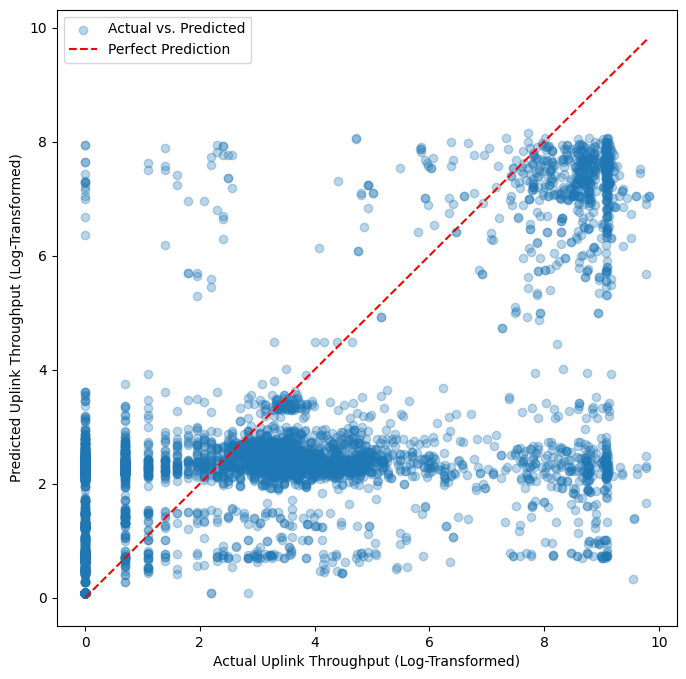

In [ ]:

plt.figure(figsize=(8, 8))
plt.scatter(y_test_ul.values, y_pred_ul_xgb, alpha=0.3, label='Actual vs. Predicted')
plt.plot([y_test_ul.min(), y_test_ul.max()], [y_test_ul.min(), y_test_ul.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual Uplink Throughput (Log-Transformed)")
plt.ylabel("Predicted Uplink Throughput (Log-Transformed)")
plt.legend()
plt.show()


In [ ]:
#LightGBM for Uplink Throughput
lgbm_ul_model = lgb.LGBMRegressor(random_state=42)
lgbm_ul_model.fit(X_train_ul, y_train_ul)
y_pred_ul_lgbm = lgbm_ul_model.predict(X_test_ul)
rmse_ul_lgbm = mean_squared_error(y_test_ul, y_pred_ul_lgbm, squared=False)
r2_ul_lgbm = r2_score(y_test_ul, y_pred_ul_lgbm)

print("Uplink Throughput Model (LightGBM):")
print(f"  RMSE: {rmse_ul_lgbm:.4f} (log scale)")
print(f"  R-squared: {r2_ul_lgbm:.4f}\\n")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9899
[LightGBM] [Info] Number of data points in the train set: 23201, number of used features: 103
[LightGBM] [Info] Start training from score 1.190567


TypeError: got an unexpected keyword argument 'squared'

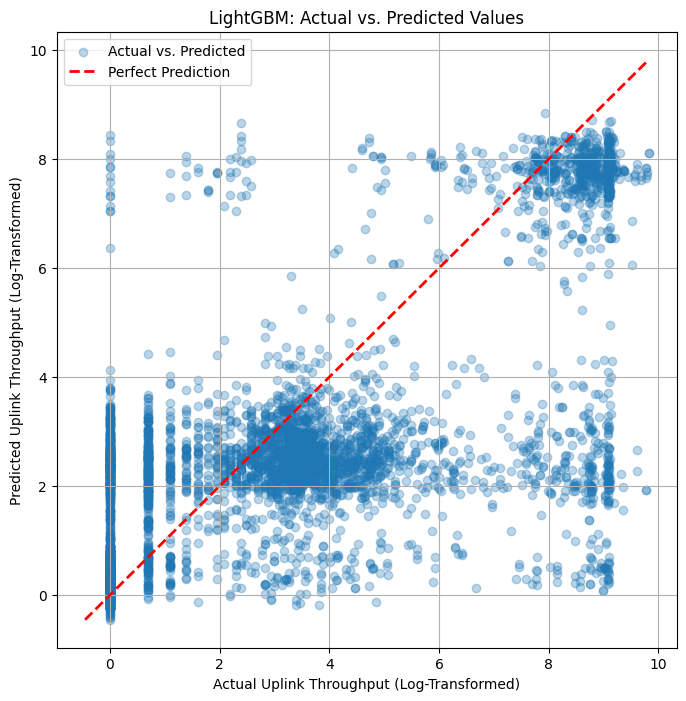

In [ ]:
plt.figure(figsize=(8, 8))

plt.scatter(y_test_ul, y_pred_ul_lgbm, alpha=0.3, label='Actual vs. Predicted')

min_val = min(y_test_ul.min(), y_pred_ul_lgbm.min())
max_val = max(y_test_ul.max(), y_pred_ul_lgbm.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

plt.xlabel("Actual Uplink Throughput (Log-Transformed)")
plt.ylabel("Predicted Uplink Throughput (Log-Transformed)")
plt.title("LightGBM: Actual vs. Predicted Values")
plt.legend()
plt.grid(True)


In [ ]:
# Random Forest for Uplink Throughput
rf_ul_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_ul_model.fit(X_train_ul, y_train_ul)
y_pred_ul_rf = rf_ul_model.predict(X_test_ul)

mse_ul_rf = mean_squared_error(y_test_ul, y_pred_ul_rf)
rmse_ul_rf = np.sqrt(mse_ul_rf)


r2_ul_rf = r2_score(y_test_ul, y_pred_ul_rf)

print("Uplink Throughput Model (Random Forest):")
print(f"  RMSE: {rmse_ul_rf:.4f} (log scale)")
print(f"  R-squared: {r2_ul_rf:.4f}")

Uplink Throughput Model (Random Forest):
  RMSE: 1.8674 (log scale)
  R-squared: 0.6027


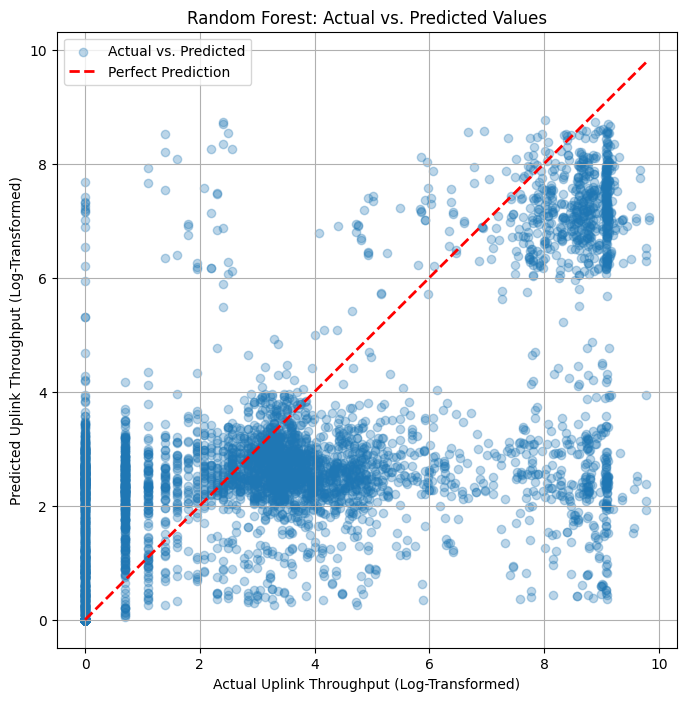

In [ ]:
plt.figure(figsize=(8, 8))

plt.scatter(y_test_ul, y_pred_ul_rf, alpha=0.3, label='Actual vs. Predicted')

min_val = min(y_test_ul.min(), y_pred_ul_rf.min())
max_val = max(y_test_ul.max(), y_pred_ul_rf.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

plt.xlabel("Actual Uplink Throughput (Log-Transformed)")
plt.ylabel("Predicted Uplink Throughput (Log-Transformed)")
plt.title("Random Forest: Actual vs. Predicted Values")
plt.legend()
plt.grid(True)


In [ ]:
X_train_dl, X_test_dl = X_train.copy(), X_test.copy()
# --- Downlink Throughput (XGBoost) ---
xgb_dl_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    early_stopping_rounds=50,
    random_state=42
)

xgb_dl_model.fit(
    X_train, y_train_dl,
    eval_set=[(X_test, y_test_dl)],
    verbose=False
)

y_pred_dl_xgb = xgb_dl_model.predict(X_test)

rmse_dl_xgb = mean_squared_error(y_test_dl, y_pred_dl_xgb, squared=False)
r2_dl_xgb = r2_score(y_test_dl, y_pred_dl_xgb)

print("Downlink Throughput Model (XGBoost):")
print(f"  RMSE: {rmse_dl_xgb:.4f} (log scale)")
print(f"  R-squared: {r2_dl_xgb:.4f}\n")


TypeError: got an unexpected keyword argument 'squared'

In [ ]:

plt.figure(figsize=(8, 8))
plt.scatter(y_test_dl, y_pred_dl_xgb, alpha=0.3, label='Actual vs. Predicted')
plt.plot([y_test_dl.min(), y_test_dl.max()], [y_test_dl.min(), y_test_dl.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual Downlink Throughput (Log-Transformed)")
plt.ylabel("Predicted Downlink Throughput (Log-Transformed)")
plt.title("XGBoost (Downlink): Actual vs. Predicted (Log Scale)")
plt.legend()
plt.show()


In [ ]:
# LightGBM for Downlink Throughput
lgbm_dl_model = lgb.LGBMRegressor(random_state=42)
lgbm_dl_model.fit(X_train_dl, y_train_dl)

y_pred_dl_lgbm = lgbm_dl_model.predict(X_test_dl)

rmse_dl_lgbm = mean_squared_error(y_test_dl, y_pred_dl_lgbm, squared=False)
r2_dl_lgbm = r2_score(y_test_dl, y_pred_dl_lgbm)

print("Downlink Throughput Model (LightGBM):")
print(f"  RMSE: {rmse_dl_lgbm:.4f} (log scale)")
print(f"  R-squared: {r2_dl_lgbm:.4f}\n")


In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test_dl, y_pred_dl_lgbm, alpha=0.3, label='Actual vs. Predicted')

min_val = min(y_test_dl.min(), y_pred_dl_lgbm.min())
max_val = max(y_test_dl.max(), y_pred_dl_lgbm.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

plt.xlabel("Actual Downlink Throughput (Log-Transformed)")
plt.ylabel("Predicted Downlink Throughput (Log-Transformed)")
plt.title("LightGBM (Downlink): Actual vs. Predicted (Log Scale)")
plt.legend()
plt.grid(True)


In [ ]:
# Random Forest for Downlink Throughput
rf_dl_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_dl_model.fit(X_train_dl, y_train_dl)

y_pred_dl_rf = rf_dl_model.predict(X_test_dl)

rmse_dl_rf = mean_squared_error(y_test_dl, y_pred_dl_rf, squared=False)
r2_dl_rf = r2_score(y_test_dl, y_pred_dl_rf)

print("Downlink Throughput Model (Random Forest):")
print(f"  RMSE: {rmse_dl_rf:.4f} (log scale)")
print(f"  R-squared: {r2_dl_rf:.4f}\n")


In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test_dl, y_pred_dl_rf, alpha=0.3, label='Actual vs. Predicted')

min_val = min(y_test_dl.min(), y_pred_dl_rf.min())
max_val = max(y_test_dl.max(), y_pred_dl_rf.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

plt.xlabel("Actual Downlink Throughput (Log-Transformed)")
plt.ylabel("Predicted Downlink Throughput (Log-Transformed)")
plt.title("Random Forest (Downlink): Actual vs. Predicted (Log Scale)")
plt.legend()
plt.grid(True)


In [ ]:
X_train_anom = X_train.copy()
X_test_anom  = X_test.copy()

log_reg_anom_model = LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000)
log_reg_anom_model.fit(X_train_anom, y_train_anom.reindex(X_train.index))

y_pred_anom = log_reg_anom_model.predict(X_test_anom)
y_pred_proba_anom = log_reg_anom_model.predict_proba(X_test_anom)[:, 1]

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
print("Anomaly Detection Model (Logistic Regression):")
print("\nClassification Report:")
print(classification_report(y_test_anom.reindex(X_test.index), y_pred_anom))

print("Confusion Matrix:")
print(confusion_matrix(y_test_anom.reindex(X_test.index), y_pred_anom))

print(f"\nAUC-ROC Score: {roc_auc_score(y_test_anom.reindex(X_test.index), y_pred_proba_anom):.4f}")


In [ ]:

cm = confusion_matrix(y_test_anom, y_pred_anom)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Anomaly', 'Anomaly'],
            yticklabels=['Not Anomaly', 'Anomaly'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Anomaly Detection')